In [1]:
%matplotlib notebook
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os, os.path
import glob
import h5py
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from mpl_toolkits import mplot3d
from scipy import ndimage, signal, interpolate
from astropy.coordinates import SkyCoord,Galactic,ICRS,Galactocentric
import astropy.coordinates as coord
from galpy.potential import NFWPotential,DoubleExponentialDiskPotential,MN3ExponentialDiskPotential,HernquistPotential,ChandrasekharDynamicalFrictionForce
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
#import seaborn as sns
from matplotlib import animation
from scipy.stats import gaussian_kde
import astropy.units as u
from galpy import potential
#from matplotlib import cm, pyplot
from galpy.potential import evaluatezforces



In [2]:
ro=8.
vo=220.

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)
    
def read_snapshot(fname='test.hdf5',read_axes='Coordinates',ptype=1):
    data = h5py.File(fname, 'r')
    group = data['PartType{}'.format(int(ptype))]
    
    try:
        dd=group[read_axes][()]
        try:
            if np.size(dd,1) ==3:
                return (dd[:,0],dd[:,1],dd[:,2])
    
        except IndexError:
            return (dd)
    
    except KeyError:
        print ("Allowed axes names %s"%group.keys())
        
        
def extract_data_of_ptype(folder="",ptype=1,nfiles=100,shift_file_ind=0,shift_ID=0,pot_acc=True):
    #currently only supports: coordinates, velocities, mass, ID, acceleration,potential
    ids=[];m=[];x=[];y=[];z=[];vx=[];vy=[];vz=[];pot=[];ax=[];ay=[];az=[];tt=[];

    time_series = [0.01*(i+shift_file_ind) for i in range(nfiles-shift_file_ind)]

    #print (time_series)

    for nn in range(shift_file_ind,nfiles):
                
        tt.append(time_series[nn-shift_file_ind])
        _x,_y,_z=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype)
        _vx,_vy,_vz=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Velocities")
        _ids=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="ParticleIDs")
        _ms=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Masses")
        
        _x = _x[_ids >=shift_ID]
        _y = _y[_ids >=shift_ID]
        _z = _z[_ids >=shift_ID]
        _vx = _vx[_ids >=shift_ID]
        _vy = _vy[_ids >=shift_ID]
        _vz = _vz[_ids >=shift_ID]
        _ms = _ms[_ids >=shift_ID]
                      
        if pot_acc:
            _pot=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Potential")
            _pot = _pot[_ids >=shift_ID]
            _ax,_ay,_az=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Acceleration")
            _ax = _ax[_ids >=shift_ID]
            _ay = _ay[_ids >=shift_ID]
            _az = _az[_ids >=shift_ID]
        
        _ids=_ids[_ids >=shift_ID]
        
                    
        id_sort = _ids.argsort()

        _ids=_ids[id_sort]
        _x=_x[id_sort]
        _y=_y[id_sort]
        _z=_z[id_sort]
        _vx=_vx[id_sort]
        _vy=_vy[id_sort]
        _vz=_vz[id_sort]
        _ms=_ms[id_sort]
        
        ids.append(_ids)
        x.append(_x)
        y.append(_y)
        z.append(_z)
        vx.append(_vx)
        vy.append(_vy)
        vz.append(_vz)
        m.append(_ms) 
        
        if pot_acc:
            _pot = _pot[id_sort]
            _ax = _ax[id_sort]
            _ay = _ay[id_sort]
            _az = _az[id_sort]
            pot.append(_pot)
            ax.append(_ax)
            ay.append(_ay)
            az.append(_az)
    
    if pot_acc:
        return (tt,ids,x,y,z,vx,vy,vz,m,pot,ax,ay,az)
            
    return (tt,ids,x,y,z,vx,vy,vz,m)

        

def make_IC(xv_d,yv_d,zv_d,vx_d,vy_d,vz_d,mv_d,fn='test',ptype=1):
    '''
    This is an example subroutine provided to demonstrate how to make HDF5-format
    ICs for GIZMO. The specific example here is arbitrary, but can be generalized
    to whatever IC you need
    
    Modified by Nil: This now takes (x,y,z,vx,vy,vz,m) of a prticular particle type
    and then generates a Gizmo compatible IC. This is useful incase we want to extract a certain subset 
    of particles from another snapshot/IC and use that as an IC for another run.
    
    As of now, it only handles one particle type at a time.
    
     
    
    '''

    fname=fn; # output filename 

    # now we get ready to actually write this out
    #  first - open the hdf5 ics file, with the desired filename
    file = h5py.File(fname,'w') 

    # set particle number of each type into the 'npart' vector
    #  NOTE: this MUST MATCH the actual particle numbers assigned to each type, i.e.
    #   npart = np.array([number_of_PartType0_particles,number_of_PartType1_particles,number_of_PartType2_particles,
    #                     number_of_PartType3_particles,number_of_PartType4_particles,number_of_PartType5_particles])
    #   or else the code simply cannot read the IC file correctly!
    Ngrains=len(xv_d)
    npart = np.array([0,0,0,0,0,0]) # we have gas and particles we will set for type 3 here, zero for all others
    npart[ptype]+=Ngrains
    # now we make the Header - the formatting here is peculiar, for historical (GADGET-compatibility) reasons
    h = file.create_group("Header");
    # here we set all the basic numbers that go into the header
    # (most of these will be written over anyways if it's an IC file; the only thing we actually *need* to be 'correct' is "npart")
    h.attrs['NumPart_ThisFile'] = npart; # npart set as above - this in general should be the same as NumPart_Total, it only differs 
                                         #  if we make a multi-part IC file. with this simple script, we aren't equipped to do that.
    h.attrs['NumPart_Total'] = npart; # npart set as above
    h.attrs['NumPart_Total_HighWord'] = 0*npart; # this will be set automatically in-code (for GIZMO, at least)
    h.attrs['MassTable'] = np.zeros(6); # these can be set if all particles will have constant masses for the entire run. however since 
                                        # we set masses explicitly by-particle this should be zero. that is more flexible anyways, as it 
                                        # allows for physics which can change particle masses 
    ## all of the parameters below will be overwritten by whatever is set in the run-time parameterfile if
    ##   this file is read in as an IC file, so their values are irrelevant. they are only important if you treat this as a snapshot
    ##   for restarting. Which you shouldn't - it requires many more fields be set. But we still need to set some values for the code to read
    h.attrs['Time'] = 0.0;  # initial time
    h.attrs['Redshift'] = 0.0; # initial redshift
    h.attrs['BoxSize'] = 1.0; # box size
    h.attrs['NumFilesPerSnapshot'] = 1; # number of files for multi-part snapshots
    h.attrs['Omega0'] = 1.0; # z=0 Omega_matter
    h.attrs['OmegaLambda'] = 0.0; # z=0 Omega_Lambda
    h.attrs['HubbleParam'] = 1.0; # z=0 hubble parameter (small 'h'=H/100 km/s/Mpc)
    h.attrs['Flag_Sfr'] = 0; # flag indicating whether star formation is on or off
    h.attrs['Flag_Cooling'] = 0; # flag indicating whether cooling is on or off
    h.attrs['Flag_StellarAge'] = 0; # flag indicating whether stellar ages are to be saved
    h.attrs['Flag_Metals'] = 0; # flag indicating whether metallicity are to be saved
    h.attrs['Flag_Feedback'] = 0; # flag indicating whether some parts of springel-hernquist model are active
    h.attrs['Flag_DoublePrecision'] = 0; # flag indicating whether ICs are in single/double precision
    h.attrs['Flag_IC_Info'] = 0; # flag indicating extra options for ICs
    ## ok, that ends the block of 'useless' parameters
    
    # Now, the actual data!
    #   These blocks should all be written in the order of their particle type (0,1,2,3,4,5)
    #   If there are no particles of a given type, nothing is needed (no block at all)
    #   PartType0 is 'special' as gas. All other PartTypes take the same, more limited set of information in their ICs
    
    # now assign the collisionless particles to PartType1. note that this block looks exactly like 
    #   what we had above for the gas. EXCEPT there are no "InternalEnergy" or "MagneticField" fields (for 
    #   obvious reasons). 
    
    # use index as id
    id_d=np.arange(0,Ngrains,1)
    
    
    p = file.create_group("PartType{}".format(ptype))
    q=np.zeros((Ngrains,3)); q[:,0]=xv_d; q[:,1]=yv_d; q[:,2]=zv_d;
    p.create_dataset("Coordinates",data=q)
    q=np.zeros((Ngrains,3)); q[:,0]=vx_d; q[:,1]=vy_d; q[:,2]=vz_d;
    p.create_dataset("Velocities",data=q)
    p.create_dataset("ParticleIDs",data=id_d)
    p.create_dataset("Masses",data=mv_d)

    # no PartType4 for this IC
    # no PartType5 for this IC

    # close the HDF5 file, which saves these outputs
    file.close()
    # all done!
    
def make_gizmo_IC(fname_list,offset_list=[],fout_name="test_out.hdf5"):
    
    '''
    This takes in a list of ICs generated by GalIC or something and combined them into one 
    IC in a format compatible with Gizmo
    
    offset_list: a list with each element an array or list of phase space offset for each file
    For no offset like for the main halo, simply put [0. 0. 0. 0. 0. 0.] 
    phase space coordinate must be in the form [x(kpc),y(kpc),z(kpc),vx(km/s),vy(km/s),vz(km/s)]
    order of offset elements must follow that in the fname list
    
        
    '''
    #set offsets to 0 in case no offset provided
    if len(offset_list) == 0:
        _ofs=np.zeros(6)
        offset_list = [_ofs]*len(fname_list)
    
    
    npart=np.array([0,0,0,0,0,0])
    pos=[None]*6
    vel=[None]*6
    mass=[None]*6
    ids=[None]*6
        
    for ii in range(6):
        x=[]
        y=[]
        z=[]
        vx=[]
        vy=[]
        vz=[]
        m=[]
        
        print (ii)
        for ff in range(len(fname_list)):
            data = h5py.File(fname_list[ff], 'r')
            if "PartType{}".format(ii) in data.keys():
                _x,_y,_z = read_snapshot(fname=fname_list[ff],read_axes='Coordinates',ptype=ii)
                _vx,_vy,_vz = read_snapshot(fname=fname_list[ff],read_axes='Velocities',ptype=ii)
                _m = read_snapshot(fname=fname_list[ff],read_axes='Masses',ptype=ii)
                              
                #add offsets
                _x+=offset_list[ff][0];_y+=offset_list[ff][1];_z+=offset_list[ff][2];
                _vx+=offset_list[ff][3];_vy+=offset_list[ff][4];_vz+=offset_list[ff][5];
                                 
                x.append(_x);y.append(_y);z.append(_z);
                vx.append(_vx);vy.append(_vy);vz.append(_vz);
                m.append(_m)
                                
                                     
            else:
                print ("No PartType %i found in %s"%(ii,fname_list[ff]))
                pass
        
        x=np.array([st for sublist in x for st in sublist]);y=np.array([st for sublist in y for st in sublist]);
        z=np.array([st for sublist in z for st in sublist]);vx=np.array([st for sublist in vx for st in sublist]);
        vy=np.array([st for sublist in vy for st in sublist]);vz=np.array([st for sublist in vz for st in sublist]);
        m=np.array([st for sublist in m for st in sublist]);
        
        print (len(x))
        ids[ii]=np.arange(0,len(m),1)
        npart[ii]+=len(x)
        pos[ii]=np.c_[x,y,z]
        vel[ii]=np.c_[vx,vy,vz]
        mass[ii]=m
        
    
    print (npart)
    # now we get ready to actually write this out
    #  first - open the hdf5 ics file, with the desired filename
    
    file = h5py.File(fout_name,'w') 

    h = file.create_group("Header");
    # here we set all the basic numbers that go into the header
    # (most of these will be written over anyways if it's an IC file; the only thing we actually *need* to be 'correct' is "npart")
    h.attrs['NumPart_ThisFile'] = npart; # npart set as above - this in general should be the same as NumPart_Total, it only differs 
                                         #  if we make a multi-part IC file. with this simple script, we aren't equipped to do that.
    h.attrs['NumPart_Total'] = npart; # npart set as above
    h.attrs['NumPart_Total_HighWord'] = 0*npart; # this will be set automatically in-code (for GIZMO, at least)
    h.attrs['MassTable'] = np.zeros(6); # these can be set if all particles will have constant masses for the entire run. however since 
                                        # we set masses explicitly by-particle this should be zero. that is more flexible anyways, as it 
                                        # allows for physics which can change particle masses 
    ## all of the parameters below will be overwritten by whatever is set in the run-time parameterfile if
    ##   this file is read in as an IC file, so their values are irrelevant. they are only important if you treat this as a snapshot
    ##   for restarting. Which you shouldn't - it requires many more fields be set. But we still need to set some values for the code to read
    h.attrs['Time'] = 0.0;  # initial time
    h.attrs['Redshift'] = 0.0; # initial redshift
    h.attrs['BoxSize'] = 1.0; # box size
    h.attrs['NumFilesPerSnapshot'] = 1; # number of files for multi-part snapshots
    h.attrs['Omega0'] = 1.0; # z=0 Omega_matter
    h.attrs['OmegaLambda'] = 0.0; # z=0 Omega_Lambda
    h.attrs['HubbleParam'] = 1.0; # z=0 hubble parameter (small 'h'=H/100 km/s/Mpc)
    h.attrs['Flag_Sfr'] = 0; # flag indicating whether star formation is on or off
    h.attrs['Flag_Cooling'] = 0; # flag indicating whether cooling is on or off
    h.attrs['Flag_StellarAge'] = 0; # flag indicating whether stellar ages are to be saved
    h.attrs['Flag_Metals'] = 0; # flag indicating whether metallicity are to be saved
    h.attrs['Flag_Feedback'] = 0; # flag indicating whether some parts of springel-hernquist model are active
    h.attrs['Flag_DoublePrecision'] = 0; # flag indicating whether ICs are in single/double precision
    h.attrs['Flag_IC_Info'] = 0; # flag indicating extra options for ICs
    ## ok, that ends the block of 'useless' parameters
    
    # Now, the actual data!
    #   These blocks should all be written in the order of their particle type (0,1,2,3,4,5)
    #   If there are no particles of a given type, nothing is needed (no block at all)
    #   PartType0 is 'special' as gas. All other PartTypes take the same, more limited set of information in their ICs
    
    # now assign the collisionless particles to PartType1. note that this block looks exactly like 
    #   what we had above for the gas. EXCEPT there are no "InternalEnergy" or "MagneticField" fields (for 
    #   obvious reasons). 
    
    for jj in range(6):
        if npart[jj] != 0 :
                        
                p = file.create_group("PartType{}".format(jj))
                p.create_dataset("Coordinates",data=pos[jj])
                p.create_dataset("Velocities",data=vel[jj])
                p.create_dataset("ParticleIDs",data=ids[jj])
                p.create_dataset("Masses",data=mass[jj])
            
                   
    file.close()
       
        
    return None

def Gizmo_to_pynbody(fn="test.hdf5",ptypes=[1,2,3,4,5],eps_list=[0.1,1.0,1.0,1.0,1.0]):
    '''
    We are going to merge all ptypes to dm
    '''
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    m=[] 
    eps=[]
    for pt in ptypes:
        _x,_y,_z = read_snapshot(fname=fn,read_axes='Coordinates',ptype=pt)
        _vx,_vy,_vz = read_snapshot(fname=fn,read_axes='Velocities',ptype=pt)
        _m=read_snapshot(fname=fn,read_axes='Masses',ptype=pt)
        
        _x = _x.tolist()
        _y = _y.tolist()
        _z = _z.tolist()
        _vx = _vx.tolist()
        _vy = _vy.tolist()
        _vz = _vz.tolist()
        _m = _m.tolist()
        
        x.append(_x)
        y.append(_y)
        z.append(_z)
        vx.append(_vx)
        vy.append(_vy)
        vz.append(_vz)
        m.append(_m)
        
        eps.append(np.ones(len(_x),dtype=np.float64).tolist())
        
    x = np.array([item for sublist in x for item in sublist])
    y = np.array([item for sublist in y for item in sublist])
    z = np.array([item for sublist in z for item in sublist])
    vx = np.array([item for sublist in vx for item in sublist])
    vy = np.array([item for sublist in vy for item in sublist])
    vz = np.array([item for sublist in vz for item in sublist])
    m = np.array([item for sublist in m for item in sublist])
    eps = np.array([item for sublist in eps for item in sublist])

    pos1= np.c_[(x,y,z)]
    vel1= np.c_[(vx,vy,vz)]
    
    f = pynbody.snapshot.new(dm=len(m))
    f['pos'] =pynbody.array.SimArray(pos1,"kpc")
    f['vel'] =pynbody.array.SimArray(vel1,'km s**-1')
    f['mass'] =pynbody.array.SimArray(m*1e10,'Msol')
    f['eps'] = pynbody.array.SimArray(eps,'kpc')
    f.physical_units()
    
    return (f)



                
  

First, we will take the GD-1 cluster, place it at the phase space coordinates consistent with $\phi_{1} = -40^{\circ}$, then we will flip its velocity and integrate in a live halo of mass resolution $10^{6} \rm{M}_{\odot}$. We will then compare the evolution by integrating the same cluster in an analogous analytic MW halo potential 

In [3]:
coord.galactocentric_frame_defaults.set('v4.0') 
o= Orbit.from_name("GD1")

c1 = coord.ICRS(ra=o.ra()*u.degree, dec=o.dec()*u.degree,
                distance=o.dist()*u.kpc,
                pm_ra_cosdec=o.pmra()*u.mas/u.yr,
                pm_dec=o.pmdec()*u.mas/u.yr,
                radial_velocity=o.vlos()*u.km/u.s)

gc1 = c1.transform_to(coord.Galactocentric)

print(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

-12.726089322382306 kpc -0.6519411336112344 kpc 5.975650034386612 kpc -73.32820069269474 km / s -210.86651691603197 km / s -100.05304504390998 km / s


Make the IC files: 1. with the live halo 2. with only the cluster (for the analytic potential)

In [4]:
dirMW = "../GALIC0/Model-MW_GB_onlyhalo_Mres1e5Msun/"
fn1 = "GD1_model_N16W2R20_eps2pcinit_noOffset.hdf5"

fn = dirMW + "snap_010.hdf5"

fn_list=[fn,fn1]
         
#fn_list = [fn1]

offset = np.array([0.,0.,0.,0.,0.,0.])
#velocity flipped
gd1_offset = np.array([gc1.x.value,gc1.y.value,gc1.z.value,-1*gc1.v_x.value,-1*gc1.v_y.value,-1*gc1.v_z.value]) 

off_list=[offset,gd1_offset]
#off_list= [gd1_offset]

#print (off_list)

make_gizmo_IC(fname_list=fn_list,offset_list=off_list,fout_name="ics/MW_GB_Mres1e5Msun_GD-1_currentPos_velflipped.hdf5")


0
No PartType 0 found in ../GALIC0/Model-MW_GB_onlyhalo_Mres1e5Msun/snap_010.hdf5
No PartType 0 found in GD1_model_N16W2R20_eps2pcinit_noOffset.hdf5
0
1
No PartType 1 found in GD1_model_N16W2R20_eps2pcinit_noOffset.hdf5
10000000
2
No PartType 2 found in ../GALIC0/Model-MW_GB_onlyhalo_Mres1e5Msun/snap_010.hdf5
No PartType 2 found in GD1_model_N16W2R20_eps2pcinit_noOffset.hdf5
0
3
No PartType 3 found in ../GALIC0/Model-MW_GB_onlyhalo_Mres1e5Msun/snap_010.hdf5
No PartType 3 found in GD1_model_N16W2R20_eps2pcinit_noOffset.hdf5
0
4
No PartType 4 found in ../GALIC0/Model-MW_GB_onlyhalo_Mres1e5Msun/snap_010.hdf5
16000
5
No PartType 5 found in ../GALIC0/Model-MW_GB_onlyhalo_Mres1e5Msun/snap_010.hdf5
No PartType 5 found in GD1_model_N16W2R20_eps2pcinit_noOffset.hdf5
0
[       0 10000000        0        0    16000        0]


Visualize!

In [5]:
dir1 = "../Gizmo_analytic/ics/GD-1_AnalyticMW_currentPos_velflipped/"
dir2 = "ics/MW_GB_Mres1e6Msun_GD-1_currentPos_velflipped/"

mm = 401
tt4a,id4a,x4a,y4a,z4a,vx4a,vy4a,vz4a,m4a= extract_data_of_ptype(folder=dir1,ptype=4,nfiles=mm,shift_file_ind=0,shift_ID=0,pot_acc=False)

#tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4 = extract_data_of_ptype(folder=dir2,ptype=4,nfiles=mm,shift_file_ind=0,shift_ID=0,pot_acc=False)


In [ ]:
kk=0

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x4a[kk],y4a[kk],s=0.5)
#plt.scatter(x4[kk],y4[kk],s=0.5,c='r')

plt.subplot(1,2,2)
plt.scatter(x4a[kk],z4a[kk],s=0.5)
plt.scatter(x4[kk],z4[kk],s=0.5,c='r')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,6))
#fig, (ax, ax1) = plt.subplots(1, 2)
ax = fig.add_subplot(111)
title = ax.set_title(r'$t$')
sct, = ax.plot([], [], "o", markersize=1,c='green')
#sct1, = ax.plot([], [], "o", markersize=0.5,c='r')
#sct2, = ax.plot([], [], "o", markersize=0.5,c='blue')
#sct3, = ax.plot([], [], "o", markersize=0.2,c='orange')
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Z (kpc)")
#ax1.set_xlabel("X (kpc)")
#ax1.set_ylabel("Z (kpc)")


def update(ifrm,xa,za,tim):
    
    sct.set_data(xa[ifrm], za[ifrm])
    #sct1.set_data(xs[ifrm], zs[ifrm])
    #sct2.set_data(xb[ifrm], zb[ifrm])
    #sct3.set_data(xc[ifrm], zc[ifrm])
      
    title.set_text(r'$t = %.2f$ Gyr'%tim[ifrm])
  

#print (xall[0:30])
#print (vxall[500:530])
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)

ani = animation.FuncAnimation(fig, update, mm, fargs=(x4a,z4a,tt4a), interval=30,repeat_delay=2000.)
#ani = animation.FuncAnimation(fig, update, nfr-shift, fargs=(si_x,si_z,x,z,a_x,a_z,tt), interval=50/fps,repeat_delay=2000.)

fn = 'pmgrid_circle_test_Tide=1'
#fn = "SIDM_Yukawa_sigma0_500000_V0_3_CircOrbit_xyprojection"
#ani.save(fn+'.mp4',writer='ffmpeg',fps=25)

Compare potential of the particles in live halo vs analytic

In [ ]:
dir1 = "../Gizmo_analytic/ics/GD-1_AnalyticMW_currentPos_velflipped/"
dir2 = "ics/MW_GB_Mres1e6Msun_GD-1_currentPos_velflipped/"

mm = 10
tt4a,id4a,x4a,y4a,z4a,vx4a,vy4a,vz4a,m4a,pot4a,ax4a,ay4a,az4a= extract_data_of_ptype(folder=dir1,ptype=4,nfiles=mm,shift_file_ind=0,shift_ID=0,pot_acc=True)

tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4,pot4,ax4,ay4,az4 = extract_data_of_ptype(folder=dir2,ptype=4,nfiles=mm,shift_file_ind=0,shift_ID=0,pot_acc=True)


In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(ax4a[0],histtype="step",bins=30,color='b')
plt.hist(ax4[0],histtype="step",bins=30,color='r')
plt.xlabel("ax")

plt.subplot(1,3,2)
plt.hist(ay4a[0],histtype="step",bins=30,color='b')
plt.hist(ay4[0],histtype="step",bins=30,color='r')
plt.xlabel("ay")


plt.subplot(1,3,3)
plt.hist(az4a[0],histtype="step",bins=30,color='b')
plt.hist(az4[0],histtype="step",bins=30,color='r')
plt.xlabel("az")
plt.savefig("acc_analytic_vs_Nbody.pdf")
plt.show()

Compute angular momentum after shifting origin to the Sun and rotate the sky such that the angular momentum points along +z axis 

<IPython.core.display.Javascript object>


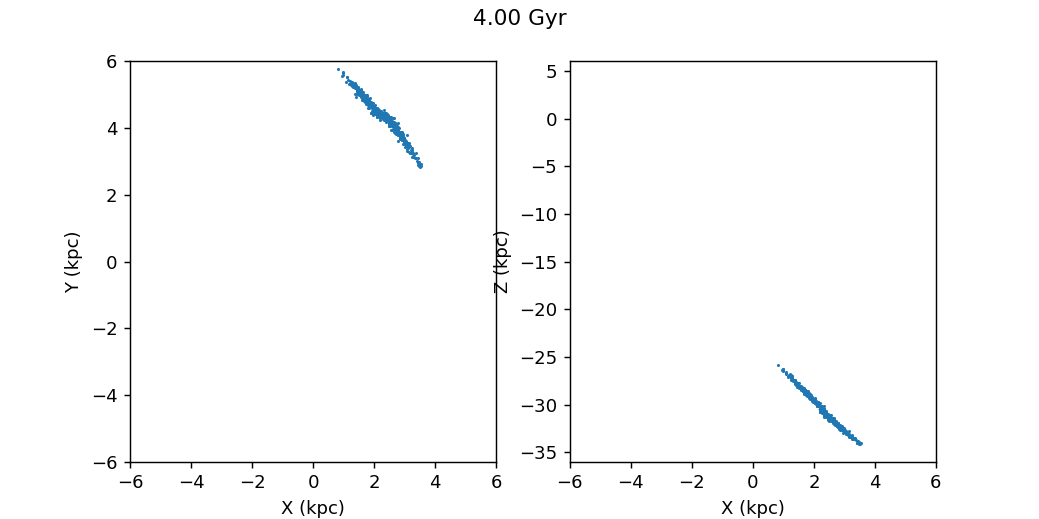

In [7]:
sn = 400
v_sun = coord.CartesianDifferential([11.1, 244, 7.25]*u.km/u.s)


gc2=coord.Galactocentric(x=x4a[sn]*u.kpc,y=y4a[sn]*u.kpc,z=z4a[sn]*u.kpc,v_x=vx4a[sn]*(u.km/u.s),\
                         v_y=vy4a[sn]*(u.km/u.s),v_z=vz4a[sn]*(u.km/u.s),galcen_distance=8.*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=0*u.pc)

gal_c2=gc2.transform_to(coord.ICRS)
gal_c2.representation_type = 'cartesian'

plt.figure(figsize=(8,4))
plt.suptitle("{:.2f} Gyr".format(0.01*sn))
plt.subplot(1,2,1)
plt.scatter(gal_c2.x.value,gal_c2.y.value,s=0.5)
plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")
plt.xlim(-6,6)
plt.ylim(-6,6)

plt.subplot(1,2,2)
plt.scatter(gal_c2.x.value,gal_c2.z.value,s=0.5)
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")
plt.xlim(-6,6)
plt.ylim(-36,6)
plt.show()


#compute angluar momentum
L = []

for ii in range(len(x4a[sn])):
    r = [gal_c2.x.value[ii],gal_c2.y.value[ii],gal_c2.z.value[ii]]
    v = [gal_c2.v_x.value[ii],gal_c2.v_y.value[ii],gal_c2.v_z.value[ii]]
    L.append(np.cross(r,v))
    


In [8]:
from galpy.util import _rotate_to_arbitrary_vector
mean_l = np.mean(L,axis=0)/np.linalg.norm(np.mean(L,axis=0))
#print (mean_l)

#print (np.atleast_2d(mean_l))

rot_mat = _rotate_to_arbitrary_vector(np.atleast_2d(mean_l),np.array([0,0,1]),inv=False,_dontcutsmall=False)

print (rot_mat)

print (np.dot(rot_mat,mean_l))
r_rot = []

for ii in range(len(x4a[sn])):
    r = [gal_c2.x.value[ii],gal_c2.y.value[ii],gal_c2.z.value[ii]]
    r_rot.append(np.dot(rot_mat,r)[0])
    
r_rot = np.array(r_rot)


[[[ 0.54512195 -0.42359581 -0.72346986]
  [-0.42359581  0.60553512 -0.67371641]
  [ 0.72346986  0.67371641  0.15065708]]]
[[-1.38777878e-17  4.16333634e-17  1.00000000e+00]]


<IPython.core.display.Javascript object>


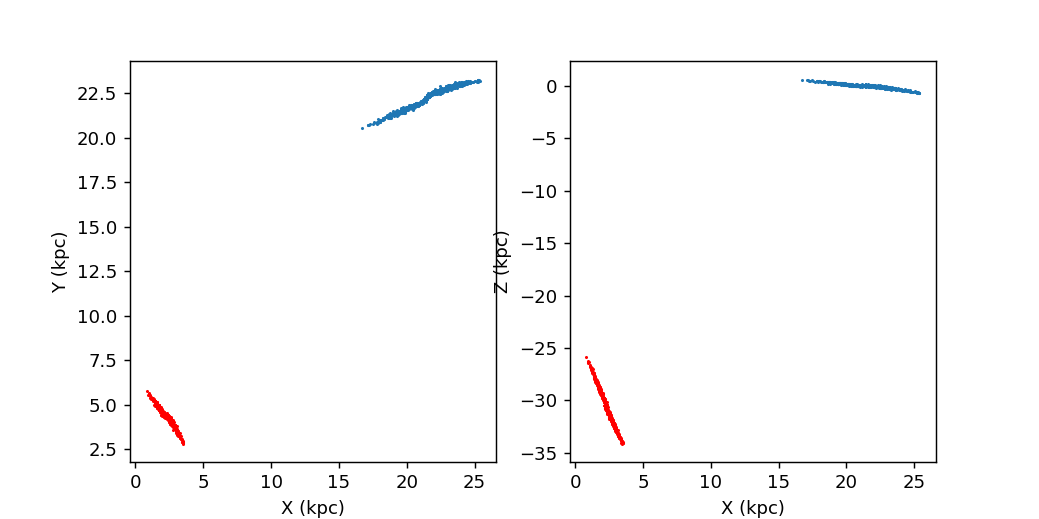

In [9]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(gal_c2.x.value,gal_c2.y.value,s=0.5,c='r')
plt.scatter(r_rot[:,0],r_rot[:,1],s=0.5)
plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-6,6)

plt.subplot(1,2,2)
plt.scatter(gal_c2.x.value,gal_c2.z.value,s=0.5,c='r')
plt.scatter(r_rot[:,0],r_rot[:,2],s=0.5)
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-36,6)
plt.show()